# Hands-on: **Reduced modeling and recovery from uncomplete measurements**

The objective of the practical session is to understand in practice how to create a reduced basis and use it for solving a state estimation inverse problem.

Our base model will be the diffusion equation:
$$-div(a(x) \nabla u(x)) = 1,\quad x \in [0, 1]^2,$$
with homogeneus Dirichlet boundary conditions. We take a piecewise constant diffusion coefficient
$$a_{|D_j} = y_j, \quad 1\leq j \leq 4,$$
on the subdomains
$$D_0 = [0, 0.5]^2, D_1 = [0.5, 1]\times[0, 0.5], D_2 = [0, 0.5]\times[0.5, 1], D_3 = [0.5, 1]^2.$$
Thus the solution $u$ depends on a parameter $y=(y_1,\dots,y_4)$ which we pick in the parameter space 
$$Y= [a_{min}, a_{max}]^4.$$

Our goal is to approximate a state $u(x,y)$ on the whole domain $x\in [0,1]^2$ for some unknown parameter $y$, based on a few point measurements $u(x^i,y)$ at chosen points $x^1,\dots,x^m\in [0,1]^2$. We procced in the following way:

Offline stage:

1) **Compute $N$ solutions** (snapshots) $u^1=u(\cdot,y^1), \dots, u^N=u(\cdot, y^N)$ from a chosen set of parameters $\{y^1, \dots ,y^N\}\in Y^N$.

2) Create a **reduced basis** $V_n$ of dimension $n\leq N$ using the $N$ precomputed snapshots. This new space is generated by the solutions $V_n \subset span\{u^1,\dots,u^N \}$: 

Online stage:

3) **Measurements**: obtain $m$ observations $u(x^i,y)$ (+noise), $1\leq i \leq m$, of a solution $u(\cdot,y)$ whith unknown parameter $y$.

4) **State estimation**: construct an approximation $\hat u\in V_n$ of $u(\cdot,y)$ based on these measurements.

5) **Error analysis**: compute the error $\|\hat u- u(\cdot,y)\|_{L^2}$ and study its behaviour depending on the reduced basis and the measurements.


## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
from typing import List

import matplotlib.pylab as plt
import numpy as np

from utils import SolutionsManager, state_estimation_pipeline, squared_subplots, plot_solutions_together, plot_approximate_solutions_together, get_vspace_dim_from_poly_degree, get_poly_degree_from_vspace_dim, calculate_approximation_statistics

np.random.seed(42)

## Parameters

In [3]:
number_of_solutions_offline = 100 # N
number_of_solutions_online = 50  # solutions to test, we will look at the average error

number_of_reduced_base_elements = 15  # n < N
number_of_measures = 50  # m >= n
diffusion_contrast_lower = 1 # a_min
diffusion_contrast_upper = 100 # a_max

We will generate the offline solutions with a Galerkine method, in the space $V$ of piecewise polynomials of degree $d$ in each subdomain $D_j$

In [4]:
lagrange_polynomials_degree = 8 # d

In [5]:
ddeg = 2 * lagrange_polynomials_degree - 1
print("The space V has dimension {}".format((ddeg)**2))
number_of_solutions_to_precalculate = number_of_solutions_offline + number_of_solutions_online

The space V has dimension 225


#### Display parameters

In [6]:
number_of_solutions_to_plot = 8
number_of_test_solutions_to_plot = number_of_solutions_to_plot
num_points_per_dim_to_plot = 50 # size of the plotted images

## **_Offline stage_**

## 1) **Compute offline solutions**

#### Solution sampling method

To create our offline solutions we need to sample the solution manifold by giving $N$ values of the parameters $y$. This can be done in many ways:

1. Uniformly sampling $y \in Y=[1, 100]^4$.
2. Making a grid of the four dimensional space $Y$.
3. Log-uniform sample $y \in Y$.
4. ...

The choice may impact the reduced space we will generate afterwards, and the solutions were we are going to test.


In [30]:
def solution_sampling_method_uniform(n, diffusion_contrast_lower, diffusion_contrast_upper):
    return np.random.uniform(diffusion_contrast_lower, diffusion_contrast_upper, size=(n, 4))

def solution_sampling_method_grid(n, diffusion_contrast_lower, diffusion_contrast_upper):
    params = np.array(list(map(np.ravel, np.meshgrid(*[np.linspace(diffusion_contrast_lower, diffusion_contrast_upper, num=int(np.ceil(n**(1/4))))]*4)))).T
    ix = np.random.choice(len(params), size=n, replace=False)
    return params[ix, :]

In [31]:
solution_sampling_method = solution_sampling_method_uniform

#### Compute solutions

In [32]:
diffusion_coefficients = solution_sampling_method(number_of_solutions_to_precalculate, diffusion_contrast_lower, diffusion_contrast_upper)
sm = SolutionsManager(lagrange_polynomials_degree)
solutions = sm.generate_solutions(diffusion_coefficients)


diffusion_coefficients_offline = diffusion_coefficients[:number_of_solutions_offline]
solutions_offline = solutions[:number_of_solutions_offline]

diffusion_coefficients_online = diffusion_coefficients[number_of_solutions_offline:]
solutions_online = solutions[number_of_solutions_offline:]

#### Visualize solutions

#### Visualize solutions intuition

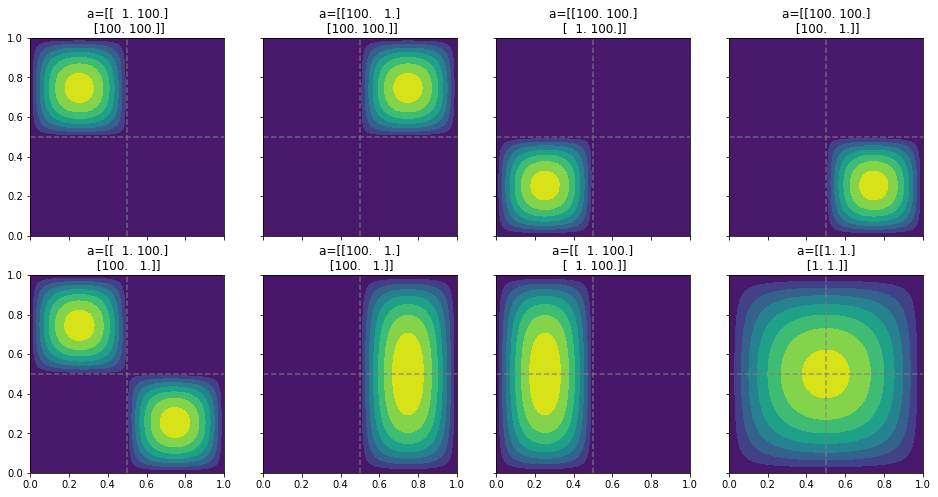

In [33]:
diffusion_coefficients_intuition = np.ones((4, 4)) * 100 - np.eye(4) * 99
diffusion_coefficients_intuition = np.concatenate([diffusion_coefficients_intuition, [[1,100, 100, 1]]], axis=0)
diffusion_coefficients_intuition = np.concatenate([diffusion_coefficients_intuition, [[100,1, 100, 1]]], axis=0)
diffusion_coefficients_intuition = np.concatenate([diffusion_coefficients_intuition, [[1,100, 1, 100]]], axis=0)
diffusion_coefficients_intuition = np.concatenate([diffusion_coefficients_intuition, [[1,1, 1, 1]]], axis=0)
solutions_intuition = sm.generate_solutions(diffusion_coefficients_intuition)

plot_solutions_together(
    sm,
    diffusion_coefficients=diffusion_coefficients_intuition, 
    solutions=solutions_intuition, 
    num_points_per_dim_to_plot=100,
    contour_levels=7
)

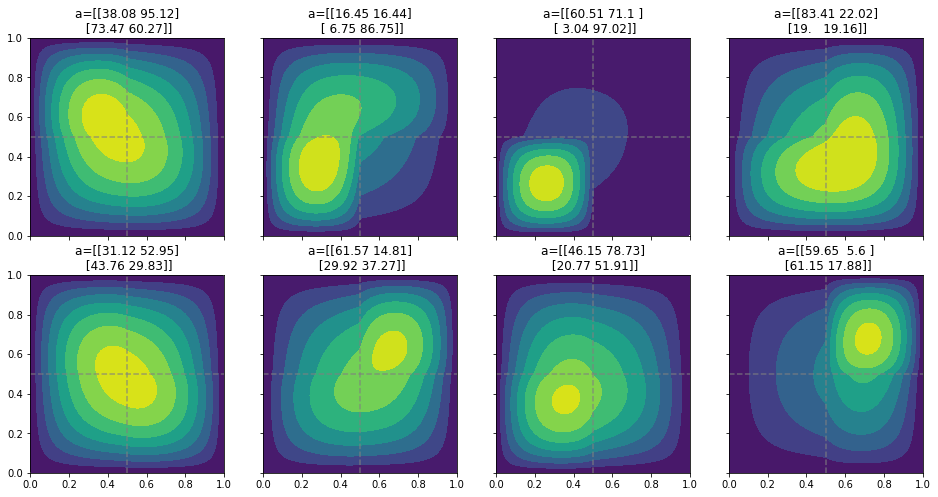

In [11]:
plot_solutions_together(
    sm,
    diffusion_coefficients=diffusion_coefficients[:number_of_test_solutions_to_plot], 
    solutions=solutions[:number_of_test_solutions_to_plot], 
    num_points_per_dim_to_plot=100,
    contour_levels=7
)


#### Play yourself to gain intuition!!!

Change the values of the parameters to see how the solution changes and gain some intuition.

You can also change the number of contour levels you want to see.

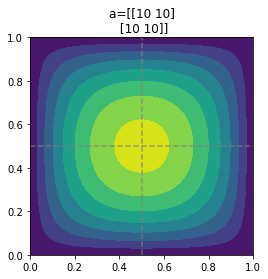

In [12]:
diffusion_coefficients_to_play = np.array([[10,10, 10, 10]])
plot_solutions_together(
    sm,
    diffusion_coefficients=diffusion_coefficients_to_play, 
    solutions=sm.generate_solutions(diffusion_coefficients_to_play), 
    num_points_per_dim_to_plot=100,
    contour_levels=7
)



## 2) **Generate Reduced Basis**

Now we are going to create the reduced basis. For that we will need the previously $N$ precomputed offline solutions and we will need also to code a method to effectively create this reduced basis subspace.

1. A simple way is just to choose randomply $n$ elements from the $N$ snapshots.
2. Other method can be to do PCA with the $N$ solutions and choose the first eigenvectors to create our base. Note that in this case the base elements will probably not be solutions to the PDE.
3. Use the greedy algorithm to incrementaly create a basis that minimizes the $L_\infty$ norm over the set of $N$ precomputed solutions.
4. For comparison, we can also use a basis of lower degree polynomials, without taking into account the physical model.
5. ...

In [34]:
#### Define reduced basis generator algorithm
"""
Scheme for a generic reduced_basis_generator method.
solutions_offline: List of solutions precalculated in an offline stage.

The output is a list of vectors forming the basis, they can be some chosen solutions (like in random or greedy methods) 
or just vectors than may not be in the solution manifold (like in PCA).
"""

def reduced_basis_generator_random(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    chosen_indexes = np.random.choice(len(solutions_offline), size=number_of_reduced_base_elements, replace=False)
    return [solutions_offline[ix] for ix in chosen_indexes]

def reduced_basis_generator_first_n(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    # if the original offline solutions are random this will also be random.
    return solutions_offline[:number_of_reduced_base_elements]

def reduced_basis_polynomial(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    return [element for element in np.eye(get_vspace_dim_from_poly_degree(get_poly_degree_from_vspace_dim(number_of_reduced_base_elements)))]

def reduced_basis_generator_pca(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    # hint: look at PCA function from sklearn library.
    raise Exception("Not implemented.")

def reduced_basis_generator_greedy(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    # hint: add the vector (solution) with maximum distance to the actual space by calculating the differences between the solutions and the projections to the actual space.
    # for the projection solve the least square problem, you can use np.linalg.lstsq
    raise Exception("Not implemented.")


In [35]:
reduced_basis_generator = reduced_basis_generator_random  # specify which reduced_basis_generator to use

#### Generate reduced basis

In [36]:
reduced_basis = reduced_basis_generator(solutions_offline, number_of_reduced_base_elements)

## **_Online stage_**

## 3) **Measurements**

Now we are ready to face a "real world" problem which consist on measuring (possibly with noise) our system at some points. Thess measurements can be specifically chosen points or just random observations. So we need to specify how thess $m$ observations are going to be obtained:
1. Sampling uniformly $m$ points in the domain.
2. Measures at points placed on a grid.
3. Sample only in one of the quadrants.
4. Adding more samples near the intersections of quadrants.
5. Sample randomly according to some other distribution.
6. ...

#### Define measurements sampling method

In [37]:
def measurements_sampling_method_uniform(number_of_measures):
    return np.random.uniform(size=(number_of_measures, 2))

def measurements_sampling_method_grid(number_of_measures):
    n_per_dim = int(np.ceil(np.sqrt(number_of_measures)))
    x, y = np.meshgrid(*[np.linspace(0, 1, num=n_per_dim)]*2)
    return np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=1)

In [38]:
measurements_sampling_method = measurements_sampling_method_uniform

#### Evaluate solutions

In [39]:
measurement_points = measurements_sampling_method(number_of_measures)

measurements_reduced_basis = sm.evaluate_solutions(measurement_points, solutions=reduced_basis)
measurements_online = sm.evaluate_solutions(measurement_points, solutions=solutions_online)

## 4) **State Estimation**

With the measurements obtained in the test set and the reduced basis we can find which is the element in $V_n$ that better fits (in some norm, like $L_2$) the observations. 

1. If, for example, we use the $L_2$ norm, we end up having to solve a linear system $Ax=b$ where $b$ are the measurement values, $A$ is a rectangular matrix $m\times n$ (whose $j$-th column corresponds to the vector of evaluations of the $j$-th element of the reduced basis at points $x^1,\dots,x^n$), and $x$ is the coefficients of the vector in $V_n$ that better fits the observations.
2. If we add different weights $w^i$ to the different evaluations (for instance, more weight near the intersections of the subdomains, where the solutions might degenerate if the contrast becomes high), we need to multiply $A$ and $b$ by a weight matrix $W=diag(w^1,\dots,w^m)$.
3. ...

In [40]:
def state_estimation_fitting_method(measurement_points, measurements, reduced_basis) -> (np.ndarray, np.ndarray):
    raise Exception("Not implemented.")
    
def state_estimation_fitting_method_least_squares(measurement_points, measurements, reduced_basis):  
    measurements_reduced_basis = sm.evaluate_solutions(measurement_points, reduced_basis)
    # solves the linear least squares problem Ax = b wehere b is the measurements; A is the rectangular matrix mxn whose columns 
    # corresponds to the m evaluations of each element of the reduced basis in the measurement points. 
    coefficients = np.linalg.lstsq(measurements_reduced_basis.T, measurements.T)[0] 
    approximate_solutions = coefficients.T @ np.array(reduced_basis)
    return coefficients, approximate_solutions
    
def state_estimation_fitting_method_weighted_least_squares(measurement_points, measurements, reduced_basis):    
    raise Exception("Not implemented.")

In [41]:
state_estimation_method = state_estimation_fitting_method_least_squares

In [42]:
coefficients, approximate_solutions = state_estimation_fitting_method_least_squares(measurement_points, measurements_online, reduced_basis)

/home/crux/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


#### Visualize approximations

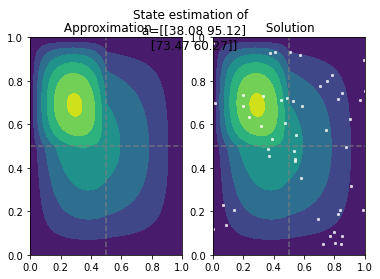

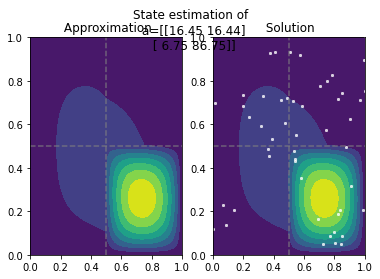

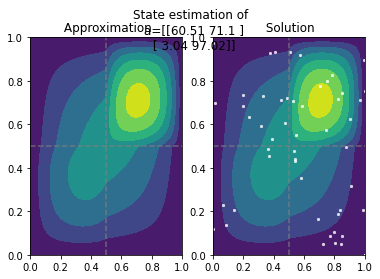

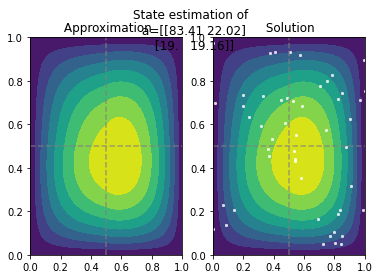

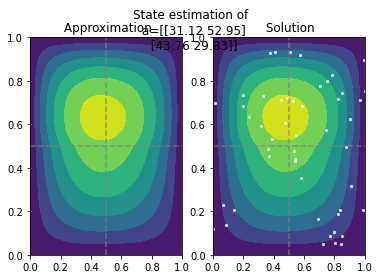

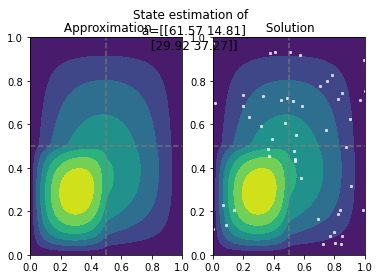

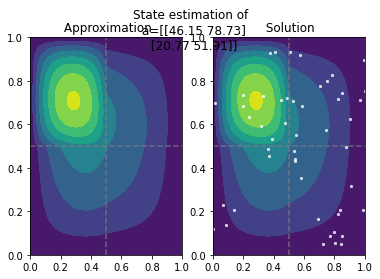

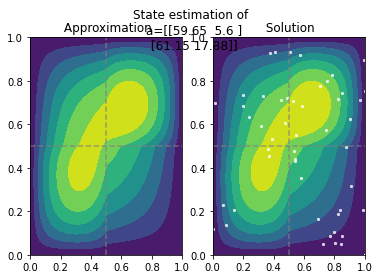

In [43]:
plot_approximate_solutions_together(
    sm, 
    diffusion_coefficients[:number_of_test_solutions_to_plot], 
    solutions_online[:number_of_test_solutions_to_plot], 
    approximate_solutions[:number_of_test_solutions_to_plot], 
    num_points_per_dim_to_plot=100,
    contour_levels=7,
    measurement_points=measurement_points
)

## 5) **Reduced basis error**

Now that we have all the steps of the state estimation pipeline we can ask ourselves how behaves empirically the approximation error of the state estimation problem when we:
1. Increase the number of basis elements $n$.
2. Change the number of measurements $m$.
3. Add noise to the measurements (by specifying the $\sigma$ of a normally distributed noise $N(0, \sigma)$).
4. Change the reduced basis.
5. Change the measurements sampling method.
6. ...

In [23]:
list_number_of_reduced_base_elements = np.arange(1, 61, dtype=int)
poly_num_elements = get_vspace_dim_from_poly_degree(np.arange(2,5))

/home/crux/Repositories/echantillonnageoptimal/src/notebooks/utils.py:263: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficients = np.linalg.lstsq(measurements_reduced_basis.T, measurements_online.T)[0]


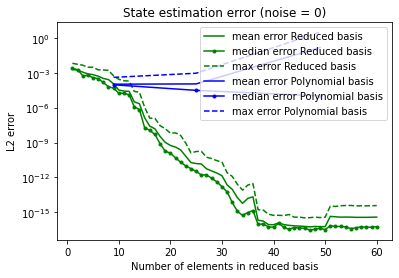

In [24]:
noise=0
rb_approximate_solutions_list = state_estimation_pipeline(solutions_offline, solutions_online, 
                                                       reduced_basis_generator=reduced_basis_generator_first_n, 
                                                       measurements_sampling_method=measurements_sampling_method_uniform, 
                                                       number_of_measures=50,
                                                       list_number_of_reduced_base_elements=list_number_of_reduced_base_elements, 
                                                          noise=noise)
poly_approximate_solutions_list = state_estimation_pipeline(solutions_offline, solutions_online, 
                                                       reduced_basis_generator=reduced_basis_polynomial, 
                                                       measurements_sampling_method=measurements_sampling_method_uniform, 
                                                       number_of_measures=50,
                                                       list_number_of_reduced_base_elements=poly_num_elements, 
                                                            noise=noise)
points = measurements_sampling_method_grid(50)

color = {"Reduced basis": "green", "Polynomial basis": "blue"}
for title, num_elements, (error_mean, error_median, error_sd, error_min, error_max) in \
[("Reduced basis", list_number_of_reduced_base_elements, calculate_approximation_statistics(points, rb_approximate_solutions_list, solutions_online)), 
 ("Polynomial basis", poly_num_elements, calculate_approximation_statistics(points, poly_approximate_solutions_list, solutions_online))]:
#     plt.figure()
    plt.yscale("log")
    plt.plot(num_elements, error_mean, label="mean error "+title, c=color[title])
    plt.plot(num_elements, error_median, '.-k', label="median error "+title, c=color[title])
#     plt.plot(num_elements, error_min, '--g' , label="min error")
    plt.plot(num_elements, error_max, '--r' , label="max error "+title, c=color[title])
#     plt.fill_between(num_elements, error_min, error_max, color="gray", alpha=0.3)
    plt.legend()
    plt.title("State estimation error (noise = {})".format(noise))
    plt.ylabel("L2 error")
    plt.xlabel("Number of elements in reduced basis")

/home/crux/Repositories/echantillonnageoptimal/src/notebooks/utils.py:263: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficients = np.linalg.lstsq(measurements_reduced_basis.T, measurements_online.T)[0]
/home/crux/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/crux/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


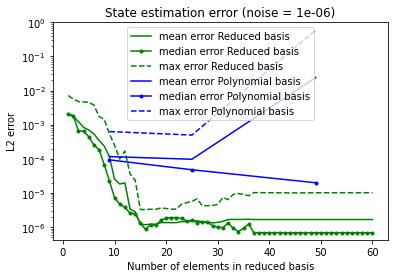

In [25]:
noise=0.000001
rb_approximate_solutions_list = state_estimation_pipeline(solutions_offline, solutions_online, 
                                                       reduced_basis_generator=reduced_basis_generator_first_n, 
                                                       measurements_sampling_method=measurements_sampling_method_uniform, 
                                                       number_of_measures=50,
                                                       list_number_of_reduced_base_elements=list_number_of_reduced_base_elements, noise=noise)
poly_approximate_solutions_list = state_estimation_pipeline(solutions_offline, solutions_online, 
                                                       reduced_basis_generator=reduced_basis_polynomial, 
                                                       measurements_sampling_method=measurements_sampling_method_uniform, 
                                                       number_of_measures=50,
                                                       list_number_of_reduced_base_elements=poly_num_elements, noise=noise)
points = measurements_sampling_method_grid(50)

color = {"Reduced basis": "green", "Polynomial basis": "blue"}
for title, num_elements, (error_mean, error_median, error_sd, error_min, error_max) in \
[("Reduced basis", list_number_of_reduced_base_elements, calculate_approximation_statistics(points, rb_approximate_solutions_list, solutions_online)), 
 ("Polynomial basis", poly_num_elements, calculate_approximation_statistics(points, poly_approximate_solutions_list, solutions_online))]:
#     plt.figure()
    plt.yscale("log")
    plt.plot(num_elements, error_mean, label="mean error "+title, c=color[title])
    plt.plot(num_elements, error_median, '.-k', label="median error "+title, c=color[title])
#     plt.plot(num_elements, error_min, '--g' , label="min error")
    plt.plot(num_elements, error_max, '--r' , label="max error "+title, c=color[title])
#     plt.fill_between(num_elements, error_min, error_max, color="gray", alpha=0.3)
    plt.legend()
    plt.title("State estimation error (noise = {})".format(noise))
    plt.ylabel("L2 error")
    plt.xlabel("Number of elements in reduced basis")
    plt.ylim((0, 1))